In [11]:
# # Chainerのインストール
# # version 2.0を使用
! pip install -U chainer==2.0

Requirement already up-to-date: chainer==2.0 in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages
Requirement already up-to-date: protobuf>=2.6.0 in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: numpy>=1.9.0 in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: six>=1.9.0 in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: filelock in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: nose in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: setuptools in /Users/tosakanaoya/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from protobuf>=2.6.0->c

In [18]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import chainer
import chainer.functions as F           # パラメータを含まない関数を収録したパッケージ
import chainer.links as L               # パラメータを含む関数を収録したパッケージ
from chainer import computational_graph # グラフを出力するパッケージ
from chainer import serializers         # モデルの保存や読込を行うパッケージ


In [16]:
# MNISTデータをロード
# notebookが保存されているディレクトリにダウンロードされます
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='.')

In [13]:
# 画像データの確認
X = mnist.data
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [14]:
# 正解ラベルの確認
y = mnist.target
y

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [15]:
# 数値をChainerが扱える型に変換
X = X.astype(np.float32)
y = y.astype(np.int32)

In [ ]:
# 画像データの確認
# float32に変換されている
X

In [ ]:
# 正解ラベルの確認
# int32に変換されている
y

In [19]:
# ベクトル化された画像を確認
# 0〜255の整数値が入っている
X[0]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,   51.,

In [20]:
# 画像の正規化
X /= 255.

In [21]:
# shapeを確認
# (画像は全部で7万枚収録, それぞれの画像が28*28=784ピクセル)
X.shape

(70000, 784)

In [22]:
# 正解ラベルの構造を確認
# (7万枚の画像に対して, ひとつの正解ラベル)
y.shape

(70000,)

In [23]:
# データを画像として出力する関数
def draw_digit(data):
    """数値の行列データを画像表示"""
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()

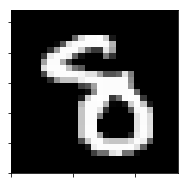

In [24]:
# データを画像として出力
# indexを指定して任意の画像を選択
index = 50000
draw_digit(X[index])

In [25]:
# 出力した画像の正解ラベルを確認
y[index]

8

In [27]:
# trainデータとtestデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [29]:
# trainデータのサイズを確認
N_train = len(X_train)
N_train

49000

In [30]:
# testデータのサイズを確認
N_test = len(X_test)
N_test

21000

In [31]:
# ニューラルネットワークの定義
# 4層のDeep Neural Network
# chainerのChainクラスを継承
class MLP(chainer.Chain):
    ''' ニューラルネットの構造を定義'''
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 900)  # 第1層からの入力784､第2層への出力900
            self.l2=L.Linear(900, 1000) # 第2層からの入力600､第3層への出力1000
            self.l3=L.Linear(1000, 500) # 第3層からの入力1000､第4層への出力500
            self.l4=L.Linear(500, 10)   # 第4層からの入力500､出力層への出力10
        
    
    ''' ニューラルネットの計算規則を定義'''
    def __call__(self, X):
        h1 = F.relu(self.l1(X))  # 1つめの隠れ層からの出力を計算
        h2 = F.relu(self.l2(h1)) # 2つめの隠れ層からの出力を計算
        h3 = F.relu(self.l3(h2)) # 3つめの隠れ層からの出力を計算
        return self.l4(h3)       # 出力層への入力を返す

In [32]:
# 分類器インスタンスの生成
# MLPクラスのインスタンスを引数として渡す
model = L.Classifier(MLP())

In [33]:
# gpuの使用の有無を指定
# 今回はCPUを想定しているため-1に指定
gpu = -1 

In [34]:
# cupyの使用の有無を指定
if gpu >= 0:
    xp = cuda.cupy
    cupy.cuda.Device(gpu).use()
    model.to_gpu()
else:
    xp = np

In [38]:
# # データをxpの32bit小数の型に変換
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# # 数値をChainerが扱える型に変換
# X = X.astype(xp.float32)
# y = y.astype(xp.int32)

In [39]:
# optimizerの定義
optimizer = chainer.optimizers.SGD()  # 今回はSGDを利用
optimizer.setup(model)                # モデルを読み込ませる

In [40]:
# ミニバッチに含まれるサンプル数を指定
# データからサンプルを100個ずつ取り出して学習する
batch_size = 100

In [41]:
# epoch数を指定
n_epoch = 20

In [42]:
# 必要なモジュールの読み込み
from chainer.datasets import tuple_dataset
from chainer import iterators, training
from chainer.training import extensions

In [43]:
# X_trainとy_trainをTupleDatasetにまとめる
train = tuple_dataset.TupleDataset(X_train, y_train)

In [44]:
# train_iterを生成
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [47]:
# Updataerを生成
# 今回はCPUの利用を想定
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)


In [48]:
# trainerの定義
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')

In [49]:
# testデータをTupleDatasetに変換
test = tuple_dataset.TupleDataset(X_test,y_test)

In [50]:
# test_iterを生成
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)

In [51]:
# Evaluatorクラスをtrainerに登録しておく
trainer.extend(extensions.Evaluator(test_iter, model))

In [52]:
# ログファイルを作成する機能を追加
trainer.extend(extensions.LogReport())

In [53]:
# 学習状況の報告を逐一出力する機能を追加
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))

In [54]:
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [55]:
# 進捗報告をする機能を追加
# trainer.extend(extensions.ProgressBar())

In [56]:
# 指定した内容で学習を実行
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           1.2501      0.737796       0.535265              0.864429                  
2           0.428952    0.88651        0.363279              0.896                     
3           0.332286    0.907122       0.31119               0.910857                  
4           0.290238    0.918163       0.282422              0.918333                  
5           0.262434    0.924796       0.257872              0.924095                  
6           0.241173    0.930857       0.239409              0.930905                  
7           0.223637    0.935857       0.224925              0.933667                  
8           0.208041    0.940041       0.212855              0.937952                  
9           0.193977    0.944653       0.201011              0.941238                  
10          0.18208     0.948327       0.190601              0.944762                  
11          0.170934    0.951469  

In [57]:
# ReportPlotによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

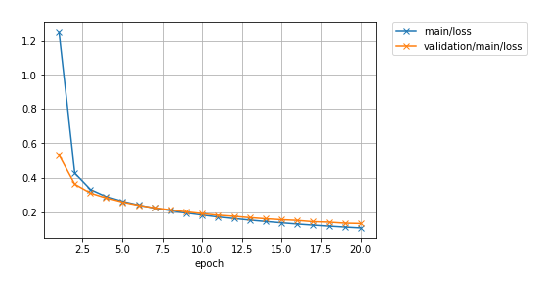

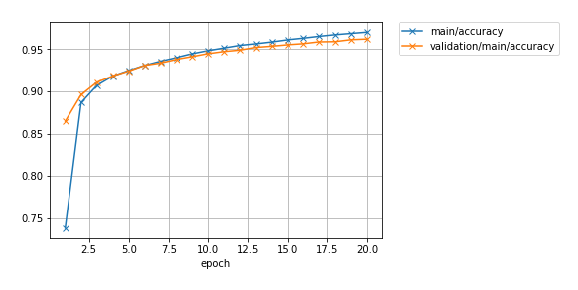

In [58]:
# 誤差と精度のグラフを描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [59]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

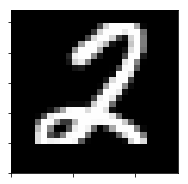

In [60]:
# testデータ内のサンプルをピックアップ
# indexを指定して任意の画像を選択
index = 123
draw_digit(X_test[index])

In [61]:
# 予測を行い､答え合わせをする
pred = predict(model, X_test[index])
ans  = y_test[index]

print('predict: ', pred)
print('answer : ', ans)

if pred == ans:
    print('正解です｡')
else:
    print('不正解です')

predict:  2
answer :  2
正解です｡


In [75]:
# 混同行列を出力
# testデータに対して行うことに注意
from sklearn.metrics import confusion_matrix as cm
result = predict(model, X_test)
cm(result, y_test)

array([[1976,    0,   11,    0,    2,   12,   18,    4,    7,   10],
       [   0, 2373,   13,    6,    5,    1,    6,   11,   20,    7],
       [   2,   10, 1944,   16,    5,    4,    1,    9,    3,    2],
       [   0,    7,   13, 1966,    0,   18,    0,    2,   24,   21],
       [   2,    1,    7,    0, 1987,    6,    8,    8,    3,   29],
       [   5,    2,    3,   32,    1, 1829,   14,    2,   12,   11],
       [   7,    0,   10,    1,   14,   11, 2024,    0,    9,    1],
       [   5,    2,   26,   12,    7,    4,    1, 2132,    6,   27],
       [   7,   11,   16,   34,    5,   20,    6,    3, 2001,   12],
       [   4,    6,    2,   15,   52,   15,    0,   20,    8, 1973]])

In [76]:
# 混同行列をグラフで出力する関数
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(xp.arange(0, 10, 1)) # x軸の目盛りを指定
    plt.yticks(xp.arange(0, 10, 1)) # y軸の目盛りを指定
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

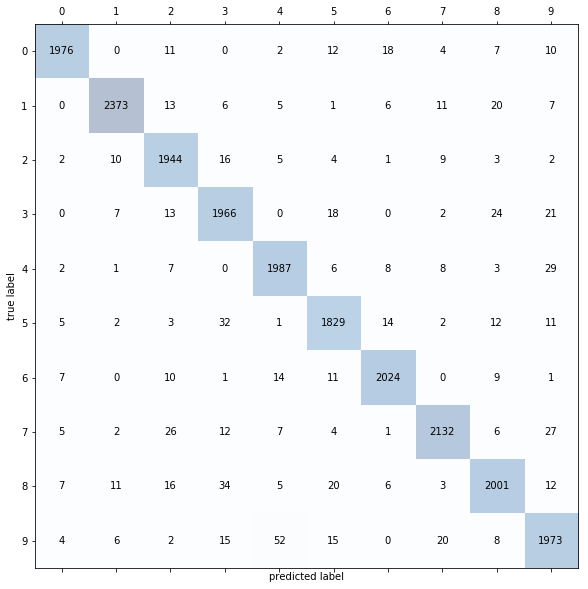

In [77]:
# 混同行列をグラフで出力
# testデータに対して行うことに注意
plot_cm(result, y_test)

In [78]:
# 性能指標を確認
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.962
recall: 0.962
precision: 0.962
f1_score: 0.962


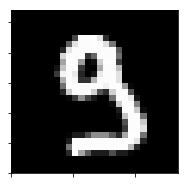

正解：9  予測：3


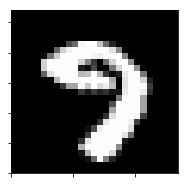

正解：9  予測：7


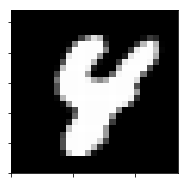

正解：4  予測：8


In [79]:
# 予想が外れたデータを表示
# 今回は3つだけ表示
count = 0
for i in range(len(y_test)):
    pre = predict(model, X_test[i]) # 予測結果
    ans =  y_test[i]                # 正解
    
    # 正解が4か9のサンプルについてだけ確認
    if (ans != 9) and (ans != 4):
        continue
        
    # 予測が間違っていたらリストへ格納
    if pre != ans:
        count += 1
        # 予測を間違えた画像を3枚だけ表示
        if count > 3:
            break
        draw_digit(X_test[i])
        print("正解：{}  予測：{}".format(ans, pre))

In [80]:
# モデルの保存
# (ファイル名, 保存したいモデルの変数名)
serializers.save_npz('mnist.model', model)
print('Saved the model.')

Saved the model.


In [81]:
# モデルの読込
# (ファイル名, 読み込みたいモデルに与える変数名)
serializers.load_npz('mnist.model', model)
print('Loaded the model.')

Loaded the model.


In [83]:
# モデルを読み込めたことを確認
model

In [84]:
%ls -la mnist.model

-rw-r--r--  1 tosakanaoya  staff  7853859 11  4 16:54 mnist.model
